# Import Python libraries for analyzing photos of space rocks

Now that we have all of the libraries downloaded, we can begin importing them into Jupyter Notebook file. We'll begin by opening or creating a Jupyter Notebook file.

Next, we import Matplotlib to help us plot our data:


In [38]:
import matplotlib.pyplot as plt

Then, we import Numpy, a library we'lll use to process large numerical matrixes (images):

In [39]:
import numpy as np

Import PyTorch to train and process deep learning and AI models:

In [40]:
import torch
from torch import nn, optim
from torch.autograd import Variable
import torch.nn.functional as F

Import torchvision (part of pyTorch) to process images and manipulate them (crop, resize):

In [41]:
import torchvision
from torchvision import datasets, transforms, models

Import Python Imagin Library (PIL) to visualize images:

In [42]:
from PIL import Image

Finally, we add two libraries that ensure that the plots are shown inline and in high resolution:

In [43]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# Import and clean data about photos of space rocks

Now that we know about cleaning and separating the data, we can actually apply these principles to our rock classification project.

Let's start by dowloading all the data we have about rock images. Then, we'll put it in the same folder as you Jupyter Notebook file. Go to [this Azure Blob storage](https://nasadata.blob.core.windows.net/nasarocks/Data.zip) and download the *Data.zip* folder. Unzop it and put it in the same folder as your Jupyter Notebook file.

Because our photos of rocks come in different sizes (small, medium, and large), we crop the imgaes so that they are the same size(22 x 224 pixels). We resize the images because computers expcet images to be same size. If images vary in size, they're not as easy for the computer to process.

We resize the images in the first part of the code. At the bottom of the code, you can see that we separate the data into a training variable and a testing variable.


In [44]:
# Tells the machine what folder contains the image data.
data_dir = './data'

# Function to read the data; crop and resize the images; and then split it into test an train chunks.

def load_split_train_test(datadir, valid_size = .2):
# This line of code transforms the images.
    train_transforms = transforms.Compose([
                                        transforms.RandomResizedCrop(224),
                                        transforms.Resize(224),
                                        transforms.ToTensor(),
                                        ])

    test_transforms = transforms.Compose([
                                        transforms.RandomResizedCrop(224),
                                        transforms.Resize(224),
                                        transforms.ToTensor(),
                                        ])
                                        
    train_data = datasets.ImageFolder(datadir, transform=train_transforms)
    test_data = datasets.ImageFolder(datadir, transform=test_transforms)

    num_train = len(train_data)
    indices = list(range(num_train))
    split = int(np.floor(valid_size * num_train))
    np.random.shuffle(indices)

    import torch
    from torch.utils.data import DataLoader
    from torch.utils.data.sampler import SubsetRandomSampler
    train_idx, test_idx = indices[split:], indices[:split]
    train_sampler = SubsetRandomSampler(train_idx)
    test_sampler = SubsetRandomSampler(test_idx)
    trainloader = DataLoader(train_data, sampler=train_sampler, batch_size=16)
    testloader = DataLoader(test_data, sampler=test_sampler, batch_size=16)
    return trainloader, testloader

# We're using 20% of data for testing.

trainloader, testloader = load_split_train_test(data_dir, .2)
print(trainloader.dataset.classes)

['Basalt', 'Highland']


# How a computer reads a photo as an image file

Now that we have our data cleaned and separated, you migh twonder how to computer reads these images. As somewhat of a spoiler, computer cn't read images the same way you or I see images.

If you know something about computers, you know that computers read things in binary: 1s and 0s. So, how can a computer read a complex image as only 1s and 0s? If you break down an image for enough, it too, is just a combination of 1s and 0s.

An image will look like the following example after a computer transforms them into numbers.

The image is broken down into pixels, and each pixel has a specific color that is identified by a code. After a computer breaks down an image into these codes, it can read and decipher the image.

# Display photos of space rocks in Jupyter Notebook

Now that we've loaded the images into the computer, let's look at a few of them. We'll give them labels that indicate what type of rock the photos contain.

The following code block reads images and then assigns each image with a correspondng rock type. The code looks long,
but that's because it needs to match each rock image with the type of rock it is, based on the folder it is in.

In [45]:
# Transform the new image into numbers and resize it.

test_transforms = transforms.Compose([transforms.RandomResizedCrop(224),
                                      transforms.Resize(224),
                                      transforms.ToTensor(),
                                    ])

# A function to randomly select a set of images

def get_random_images(num):
    data = datasets.ImageFolder(data_dir, transform=test_transforms)
    classed = data.classes
    indices = list(range(len(data)))
    np.random.shuffle(indices)
    idx = indices[:num]
    from torch.utils.data.sampler import SubsetRandomSampler
    sampler = SubsetRandomSampler(idx)
    loader = torch.utils.data.DataLoader(data, sampler=sampler, batch_size=num)
    dataiter = iter(loader)
    images, labels = dataiter.next()
    return images, labels

The following code actually shows you some images that you loaded into the program:

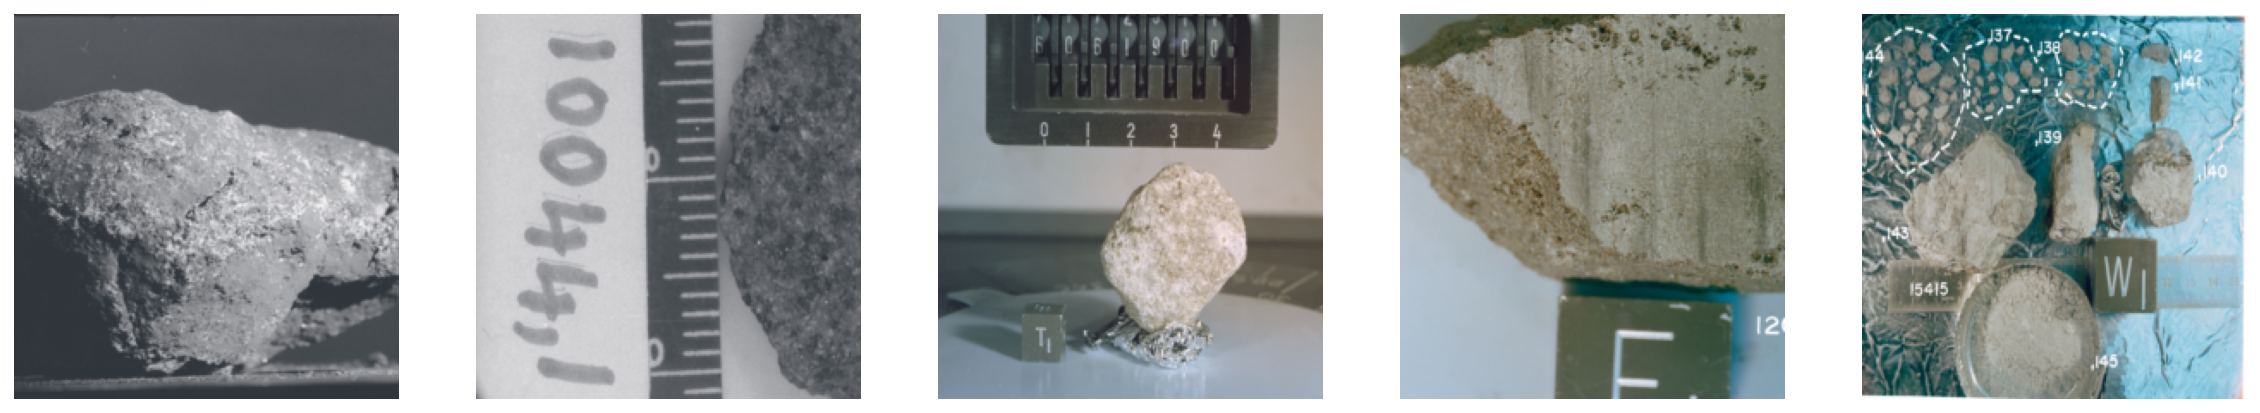

In [46]:
# How many images do you want to see? It's set to 5, but you can change the number

images, labels = get_random_images(5)
to_pil = transforms.ToPILImage()
fig =plt.figure(figsize=(20, 20))
classes = trainloader.dataset.classes

for ii in range(len(images)):
    image = to_pil(images[ii])
    sub = fig.add_subplot(1, len(images), ii+1)
    plt.axis('off')
    plt.imshow(image)

plt.show()

We use the PIL library here to manipulate the iamges, so they look appealing when we print them. We use the plt.show to actually print the images.

# Build a neural network to classify space rocks

Now, let's build a neural network/deep learning network to learn the associations between featuers (for example, curves, edges, and texture) and each rock type.

The way a neural network works is very similar to how our brains work. The human brain consists of neurons or nerve cells that transmit and process information it receives from our senses. Many of the nerve cells are arranged together to form a network of nerves in our brain. The nerves pass electrical impulses from one neuron to next neuron.

Run the following code to tell your cimputer the most efficient way to create a neural network:

In [49]:
# Determine wheter you're usinga CPU or a GPU to build the deep learnig network.

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = models.resnet50(pretrained=True)


Neural networks have millions of neurons and nerves. To build a functional neural network, we wire them together in two steps:

1. Build all the neurons.
2. Wire the neurons in an appropriate way (there are thousands of ways to wire neurons).


In [53]:
# Builds all the neurons

for param in model.parameters():
    param.requires_grad = False

# The parameters of our deep learning model.

model.fc = nn.Sequential(nn.Linear(2048, 512),
                        nn.ReLU(),
                        nn.Dropout(0.2),
                        nn.Linear(512, 2),
                        nn.LogSoftmax(dim=1))
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.003)
model.to(device)
print('done')

done


The neural network goes back and forth many times until it learns the best associations (wiring) between features and rock types.